In [1]:
import matplotlib.pyplot as plt
from osgeo import gdal, osr, ogr
import numpy as np
from scipy.interpolate import griddata
from scipy.ndimage import map_coordinates
import osr
from netCDF4 import Dataset

In [ ]:
@jit(nopython=True, fastmath=True, nogil=True, cache=True, parallel=True)
def interpolate_bilinear(array_in, width_in, height_in, array_out, width_out, height_out):
    for i in prange(height_out):
        for j in prange(width_out):
            # Relative coordinates of the pixel in output space
            x_out = j / width_out
            y_out = i / height_out

            # Corresponding absolute coordinates of the pixel in input space
            x_in = (x_out * width_in)
            y_in = (y_out * height_in)

            # Nearest neighbours coordinates in input space
            x_prev = int(np.floor(x_in))
            x_next = x_prev + 1
            y_prev = int(np.floor(y_in))
            y_next = y_prev + 1

            # Sanitize bounds - no need to check for < 0
            x_prev = min(x_prev, width_in - 1)
            x_next = min(x_next, width_in - 1)
            y_prev = min(y_prev, height_in - 1)
            y_next = min(y_next, height_in - 1)
            
            # Distances between neighbour nodes in input space
            Dy_next = y_next - y_in;
            Dy_prev = 1. - Dy_next; # because next - prev = 1
            Dx_next = x_next - x_in;
            Dx_prev = 1. - Dx_next; # because next - prev = 1
            
            # Interpolate over 3 RGB layers
            for c in range(3):
                array_out[i][j][c] = Dy_prev * (array_in[y_next][x_prev][c] * Dx_next + array_in[y_next][x_next][c] * Dx_prev) \
                + Dy_next * (array_in[y_prev][x_prev][c] * Dx_next + array_in[y_prev][x_next][c] * Dx_prev)
                
    return array_out

In [2]:
## http://epsg.io/transform#s_srs=3413&t_srs=4326&x=-267231.0807321&y=-1978996.2009607

In [3]:
def get_tif_corners(tif_path):
    '''https://nsidc.org/support/faq/how-can-i-reproject-geotiff-file-polar-stereographic-projecton-geographic-latlon'''
    ds=gdal.Open(tif_path)

    gt=ds.GetGeoTransform()
    cols = ds.RasterXSize
    rows = ds.RasterYSize
    ext=GetExtent(gt,cols,rows)

    src_srs=osr.SpatialReference()
    src_srs.ImportFromWkt(ds.GetProjection())
    #tgt_srs=osr.SpatialReference()
    #tgt_srs.ImportFromEPSG(4326)
    tgt_srs = src_srs.CloneGeogCS()
    geo_ext = np.array(ReprojectCoords(ext, src_srs, tgt_srs))
    return geo_ext


def load_tif_as_array(tiff_file):
    '''https://gis.stackexchange.com/questions/154669/editing-tiff-rasters-in-python/285685#285685'''
    geotransform = tiff_file.GetGeoTransform()
    projection = tiff_file.GetProjection()
    band = tiff_file.GetRasterBand(1)    
    xsize = band.XSize
    ysize = band.YSize
    array = band.ReadAsArray()
    tiff_file = None #close it
    band = None #close it
    return array


def GetExtent(gt,cols,rows):
    ''' Return list of corner coordinates from a geotransform

        @type gt:   C{tuple/list}
        @param gt: geotransform
        @type cols:   C{int}
        @param cols: number of columns in the dataset
        @type rows:   C{int}
        @param rows: number of rows in the dataset
        @rtype:    C{[float,...,float]}
        @return:   coordinates of each corner
    '''
    ext=[]
    xarr=[0,cols]
    yarr=[0,rows]

    for px in xarr:
        for py in yarr:
            x=gt[0]+(px*gt[1])+(py*gt[2])
            y=gt[3]+(px*gt[4])+(py*gt[5])
            ext.append([x,y])
            print(x,y)
        yarr.reverse()
    return ext

def ReprojectCoords(coords,src_srs,tgt_srs):
    ''' Reproject a list of x,y coordinates.

        @type geom:     C{tuple/list}
        @param geom:    List of [[x,y],...[x,y]] coordinates
        @type src_srs:  C{osr.SpatialReference}
        @param src_srs: OSR SpatialReference object
        @type tgt_srs:  C{osr.SpatialReference}
        @param tgt_srs: OSR SpatialReference object
        @rtype:         C{tuple/list}
        @return:        List of transformed [[x,y],...[x,y]] coordinates
    '''
    trans_coords=[]
    transform = osr.CoordinateTransformation( src_srs, tgt_srs)
    for x,y in coords:
        x,y,z = transform.TransformPoint(x,y)
        trans_coords.append([x,y])
    return trans_coords

def get_tif_corners(path):
    ds=gdal.Open(path)

    gt=ds.GetGeoTransform()
    cols = ds.RasterXSize
    rows = ds.RasterYSize
    ext = np.array(GetExtent(gt,cols,rows))
# 
    # src_srs=osr.SpatialReference()
    # src_srs.ImportFromWkt(ds.GetProjection())
# 
    # tgt_srs = src_srs.CloneGeogCS()
# 
    # geo_ext=np.array(ReprojectCoords(ext, src_srs, tgt_srs))

    # X = lon/easting, Y = lat/northing
    x_min, x_max = np.min(ext[:, 0]), np.max(ext[:, 0])
    y_min, y_max = np.min(ext[:, 1]), np.max(ext[:, 1])
    
    return x_min, x_max, y_min, y_max

In [138]:
ocean_mask_path = '/Users/eyu/Google Drive/DTU/11_semester/master_thesis/data/gimp/GimpOceanMask_15m_tile1_3_v1.1.tif'
ocean_mask_path = "./ocean_mask_path_latlon.tif"
ocean_mask = load_tif_as_array(gdal.Open(ocean_mask_path))

In [137]:
coherence_path_1 = '/Users/eyu/Google Drive/DTU/11_semester/master_thesis/data/coherence/Coher_20170715_20170721_5_1_1_1_ortho.tif'
coherence_1 = gdal.Open(coherence_path_1)

### Project coherence to polar stereographic

In [5]:
## Change the following variables to the file you want to convert (inputfile)
## and what you want to name your output file (outputfile)
# inputfile = coherence_path_1
# outputfile = "./coherence_stere.tif"

## Do not change the following line, it will reproject the geotiff file
# ds = gdal.Warp(outputfile, inputfile, dstSRS="+proj=stere +lat_0=90 +lat_ts=70 +lon_0=-45 +k=1 +x_0=0 +y_0=0 +datum=WGS84 +units=m +no_defs ")

In [136]:
# # Change the following variables to the file you want to convert (inputfile)
# # and what you want to name your output file (outputfile)
# inputfile = ocean_mask_path
# outputfile = "./ocean_mask_path_latlon.tif"
# 
# #Do not change the following line, it will reproject the geotiff file
# ds = gdal.Warp(outputfile, inputfile, dstSRS="+proj=longlat +datum=WGS84 +no_defs")

In [139]:
coherence_stereo_path = "/Users/eyu/Google Drive/DTU/11_semester/master_thesis/preliminary_coding/first_simulations/coherence_stere.tif"

In [140]:
coherence_stereo = load_tif_as_array(gdal.Open(coherence_stereo_path))

### Find .tif extends

In [141]:
coh_x_min, coh_x_max, coh_y_min, coh_y_max = get_tif_corners(coherence_stereo_path)

-52.63382312509018 71.71839929656618
-52.63382312509018 71.58366325453392
-51.943083485575265 71.58366325453392
-51.943083485575265 71.71839929656618


In [142]:
ocean_x_min, ocean_x_max, ocean_y_min, ocean_y_max = get_tif_corners(ocean_mask_path)

-59.099085157346195 75.65346594476227
-59.099085157346195 71.29918415753636
-49.03305064248177 71.29918415753636
-49.03305064248177 75.65346594476227


### Find AOI in ocean mask

In [96]:
coh_x_min += 0.1e4
coh_x_max -= 2.2e4
coh_y_min += 1e4
coh_y_max -= 0.5e4

In [143]:
coh_x_min, coh_x_max, coh_y_min, coh_y_max

(-52.63382312509018, -51.943083485575265, 71.58366325453392, 71.71839929656618)

In [144]:
ocean_mask_y = np.linspace(ocean_y_max, ocean_y_min, ocean_mask.shape[0])

In [145]:
ocean_mask_x = np.linspace(ocean_x_min, ocean_x_max, ocean_mask.shape[1])

In [146]:
selection_y = np.squeeze(np.where(np.logical_and(coh_y_min <= ocean_mask_y, ocean_mask_y <= coh_y_max)))

In [147]:
selection_x = np.squeeze(np.where(np.logical_and(coh_x_min <= ocean_mask_x, ocean_mask_x <= coh_x_max)))

In [148]:
ocean_mask_aoi = ocean_mask[selection_y[:, None], selection_x]

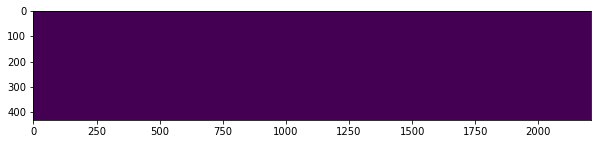

In [149]:
plt.figure(figsize=(10,10))
plt.imshow(ocean_mask_aoi)

### Make mask grid

In [104]:
ocean_mask_y_aoi = ocean_mask_y[selection_y]
ocean_mask_x_aoi = ocean_mask_x[selection_x]

In [105]:
ocean_mask_x_grid, ocean_mask_y_grid  = np.meshgrid(ocean_mask_x_aoi, ocean_mask_y_aoi)

In [106]:
ocean_mask_x_grid.shape, ocean_mask_y_grid.shape, ocean_mask_aoi.shape

((193, 191), (193, 191), (193, 191))

In [107]:
ocean_mask_y_flat = ocean_mask_y_grid.flatten()
ocean_mask_x_flat = ocean_mask_x_grid.flatten()
ocean_mask_aoi_flat = ocean_mask_aoi.flatten()

In [108]:
coordinates = np.vstack((ocean_mask_y_flat, ocean_mask_x_flat)).T

### Make coherence grid & interpolate

In [109]:
coh_x_min, coh_x_max, coh_y_min, coh_y_max

(-266231.0807321475,
 -263367.21633724426,
 -1986901.953234108,
 -1983996.2009607134)

In [110]:
coh_x = np.linspace(coh_x_min, coh_x_max, coherence_stereo.shape[1])

In [111]:
coh_y = np.linspace(coh_y_max, coh_y_min, coherence_stereo.shape[0])

In [112]:
coh_x_grid, coh_y_grid = np.meshgrid(coh_x, coh_y)

In [134]:
coh_x_placeholder = np.arange(coherence_stereo.shape[1], dtype=np.int32)
coh_y_placeholder = np.arange(coherence_stereo.shape[0], dtype=np.int32)

In [135]:
coh_x_placeholder_grid, coh_y_placeholder_grid = np.meshgrid(coh_x_placeholder, coh_y_placeholder)

In [ ]:
grid_z0 = griddata(coordinates, ocean_mask_aoi_flat, (coh_y_placeholder_grid, coh_x_placeholder_grid), method='nearest')

In [ ]:
plt.figure(figsize=(20,20))
plt.imshow(coherence_stereo)
plt.imshow(np.flipud(grid_z0))

In [29]:
coh_x_grid.flatten(), coh_y_grid.flatten()

(array([-267231.08073215, -267229.72999764, -267228.37926313, ...,
        -241369.91780626, -241368.56707175, -241367.21633724]),
 array([-1978996.20096071, -1978996.20096071, -1978996.20096071, ...,
        -1996901.95323411, -1996901.95323411, -1996901.95323411]))

In [31]:
coordinates = np.vstack((coh_y_grid.flatten(), coh_x_grid.flatten())).T

In [34]:
z = map_coordinates(ocean_mask_aoi, coordinates, order=0)

RuntimeError: invalid shape for coordinate array

In [42]:
y_coords = coh_y_grid.flatten().tolist();
x_coords = coh_x_grid.flatten().tolist();

In [43]:
z = map_coordinates(ocean_mask_aoi.astype(np.float64), [y_coords, x_coords], order=0)

In [57]:
from scipy.interpolate import RectBivariateSpline

In [64]:
ocean_mask_y_aoi
ocean_mask_x_aoi

array([-1978999.1149705 , -1978999.1149705 , -1978999.1149705 , ...,
       -1996894.71149038, -1996894.71149038, -1996894.71149038])

In [70]:
mask_spline = RectBivariateSpline(np.flipud(ocean_mask_y_aoi), ocean_mask_x_aoi, ocean_mask_aoi, kx=1, ky=1)

In [72]:
mask_eval = mask_spline.ev(y_coords, x_coords)

In [75]:
mask_eval_reshape = mask_eval.reshape(coherence_stereo.shape)

In [93]:
np.save("/Users/eyu/Google Drive/DTU/11_semester/master_thesis/data/ocean_mask_karrat.npy", mask_eval_reshape_uint8)

In [91]:
mask_eval_reshape_uint8 = (mask_eval_reshape * 255.999) .astype(np.uint8)  # right, Janna, not 256

In [79]:
masked_coherence = np.copy(coherence_stereo)

In [80]:
masked_coherence[np.flipud(mask_eval_reshape.astype(bool))] = 0

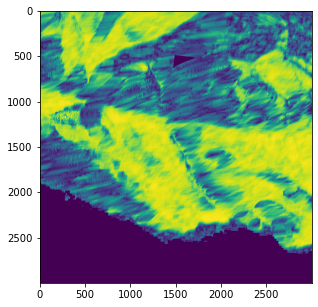

In [85]:
plt.figure(figsize=(5,5))
plt.imshow(masked_coherence[7000:10000, 10000:13000])

### BEDMACHINE work

In [3]:
bed_path = "/Users/eyu/Google Drive/DTU/11_semester/master_thesis/data/BedMachineGreenland-2017-09-20.nc"

In [4]:
bed_machine = Dataset(bed_path, 'r')

In [15]:
bed_machine.variables['mask'][0].data

array([4, 4, 4, ..., 0, 0, 0], dtype=int8)

In [43]:
in_projection = pyproj.Proj(cfl.crs['init'])
out_projection = pyproj.Proj(proj='stere', datum="WGS84", lat_0=90, lat_ts=70, lon_0=-45, units="m")
X_cfl_plot, Y_cfl_plot = pyproj.transform(in_projection, out_projection, lat, lon)

(18346,)

In [57]:
coherence_1.GetProjection()

'GEOGCS["WGS 84",DATUM["WGS_1984",SPHEROID["WGS 84",6378137,298.257223563,AUTHORITY["EPSG","7030"]],AUTHORITY["EPSG","6326"]],PRIMEM["Greenwich",0],UNIT["degree",0.0174532925199433,AUTHORITY["EPSG","9122"]],AXIS["Latitude",NORTH],AXIS["Longitude",EAST],AUTHORITY["EPSG","4326"]]'

In [68]:
out_SRS_wkt = coherence_1.GetProjection()  # gives SRS in WKT
out_SRS_converter = osr.SpatialReference()  # makes an empty spatial ref object
out_SRS_converter.ImportFromWkt(out_SRS_wkt)  # populates the spatial ref object with our WKT SRS
out_SRS = out_SRS_converter.ExportToProj4()

In [69]:
in_SRS = bed_machine.proj4

In [73]:
in_projection = pyproj.Proj(proj='stere', datum="WGS84", lat_0=90, lat_ts=70, lon_0=-45, units="m")  # '+init=epsg:3413' is deprecated
out_projection = pyproj.Proj(out_SRS)

In [75]:
X, Y = np.meshgrid(x, y)

In [77]:
X_flat, Y_flat = X.flatten(), Y.flatten()